In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Train-dataset/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2868 images belonging to 11 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/valid/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 161 images belonging to 11 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, pooling = 'avg')

In [ ]:
for layer in conv_base.layers[:299]:
  layer.trainable = False
for layer in conv_base.layers[299:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

print("Done")

Done


In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d_95 False
2 batch_normalization_94 True
3 activation_94 False
4 conv2d_96 False
5 batch_normalization_95 True
6 activation_95 False
7 conv2d_97 False
8 batch_normalization_96 True
9 activation_96 False
10 max_pooling2d_4 False
11 conv2d_98 False
12 batch_normalization_97 True
13 activation_97 False
14 conv2d_99 False
15 batch_normalization_98 True
16 activation_98 False
17 max_pooling2d_5 False
18 conv2d_103 False
19 batch_normalization_102 True
20 activation_102 False
21 conv2d_101 False
22 conv2d_104 False
23 batch_normalization_100 True
24 batch_normalization_103 True
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_100 False
29 conv2d_102 False
30 conv2d_105 False
31 conv2d_106 False
32 batch_normalization_99 True
33 batch_normalization_101 True
34 batch_normalization_104 True
35 batch_normalization_105 True
36 activation_99 False
37 activation_101 False
38 activation_104 False
39 activation_105 False
40 mixed0 False
41 

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3,(3,3), padding='same')(input_tensor)

In [ ]:
x = conv_base(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(11, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 224, 224, 3)       30        
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                22539     
Total params: 26,021,705
Trainable params: 4,629,353
Non-trainable params: 21,392,352
__________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/KTH-Colour/Inspection3_GreyScale_K-Th.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=359,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=20,epochs=120,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/120
359/359 [==============================] - ETA: 0s - loss: 2.5483 - accuracy: 0.5875
Epoch 00001: val_loss improved from inf to 1.75719, saving model to /content/drive/My Drive/KTH-Colour/Inspection3_GreyScale_K-Th.h5
359/359 [==============================] - 2680s 7s/step - loss: 2.5483 - accuracy: 0.5875 - val_loss: 1.7572 - val_accuracy: 0.6938
Epoch 2/120
358/359 [============================>.] - ETA: 0s - loss: 1.3482 - accuracy: 0.7353
Epoch 00002: val_loss did not improve from 1.75719
359/359 [==============================] - 18s 49ms/step - loss: 1.3480 - accuracy: 0.7350 - val_loss: 3.0259 - val_accuracy: 0.3812
Epoch 3/120
359/359 [==============================] - ETA: 0s - loss: 1.0703 - accuracy: 0.7681
Epoch 00003: val_loss did not improve from 1.75719
359/359 [==============================] - 17s 49ms/step - loss: 1.0703 - accuracy: 0.7681 - val_loss: 3.4899 - val_accuracy: 0.4437

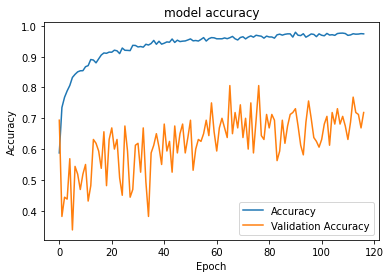

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

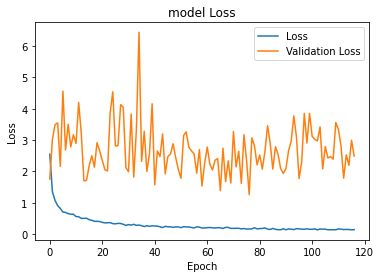

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 166 images belonging to 11 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  9,
        0,  0,  6,  2,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  6,  3,  3,  3,  3,  2,  4, 10, 10,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2, 10,  4, 10,  4,  5,
        8,  5,  5,  2,  6,  6,  6,  6,  6,  4,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  2,  6,  2,  2,  6,  6,  6,  7,  9,  9,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 10,  4,  9, 10,  0,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.8554216867469879


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.872538834347166


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.8554216867469879


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.8566401912614022


**Processing for colour Data.**

In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Train-dataset/', target_size=(224,224), batch_size=8)

Found 2868 images belonging to 11 classes.


In [ ]:
Colour_ValidData =  TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/valid/', target_size=(224,224), batch_size=8)

Found 161 images belonging to 11 classes.


In [ ]:
conv_base_colour = InceptionV3(weights = 'imagenet', include_top = False, pooling = 'avg')

In [ ]:
for layer in conv_base_colour.layers[:299]:
  layer.trainable = False
for layer in conv_base_colour.layers[299:]:
  layer.trainable = True
for layer in conv_base_colour.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

print("Done")

Done


In [ ]:
for i, layer in enumerate(conv_base_colour.layers):
   print(i, layer.name, layer.trainable)

0 input_5 False
1 conv2d_190 False
2 batch_normalization_188 True
3 activation_188 False
4 conv2d_191 False
5 batch_normalization_189 True
6 activation_189 False
7 conv2d_192 False
8 batch_normalization_190 True
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_193 False
12 batch_normalization_191 True
13 activation_191 False
14 conv2d_194 False
15 batch_normalization_192 True
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_198 False
19 batch_normalization_196 True
20 activation_196 False
21 conv2d_196 False
22 conv2d_199 False
23 batch_normalization_194 True
24 batch_normalization_197 True
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_195 False
29 conv2d_197 False
30 conv2d_200 False
31 conv2d_201 False
32 batch_normalization_193 True
33 batch_normalization_195 True
34 batch_normalization_198 True
35 batch_normalization_199 True
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activation_199 False
4

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,3))
x = conv_base_colour(input_tensor)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(11, activation='softmax')(x)

In [ ]:
colour_model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
colour_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/KTH-Colour/Inspectionv3_KTh-colour.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = colour_model.fit_generator(steps_per_epoch=359,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=20,epochs=120,callbacks=callBacks)

Epoch 1/120
359/359 [==============================] - ETA: 0s - loss: 2.4002 - accuracy: 0.6294
Epoch 00001: val_loss improved from inf to 1.66022, saving model to /content/drive/My Drive/KTH-Colour/Inspectionv3_KTh-colour.h5
359/359 [==============================] - 20s 56ms/step - loss: 2.4002 - accuracy: 0.6294 - val_loss: 1.6602 - val_accuracy: 0.6812
Epoch 2/120
358/359 [============================>.] - ETA: 0s - loss: 1.1444 - accuracy: 0.7948
Epoch 00002: val_loss did not improve from 1.66022
359/359 [==============================] - 18s 51ms/step - loss: 1.1430 - accuracy: 0.7950 - val_loss: 1.7300 - val_accuracy: 0.6250
Epoch 3/120
359/359 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.7929
Epoch 00003: val_loss improved from 1.66022 to 1.49645, saving model to /content/drive/My Drive/KTH-Colour/Inspectionv3_KTh-colour.h5
359/359 [==============================] - 21s 57ms/step - loss: 0.9800 - accuracy: 0.7929 - val_loss: 1.4965 - val_accuracy: 0.

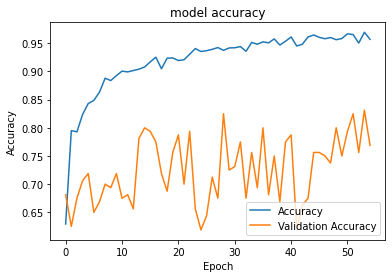

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

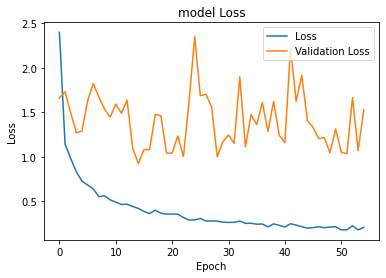

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/KTH-Colour/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 166 images belonging to 11 classes.


In [ ]:
Colour_predict = colour_model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  6,  0,  0, 10,
        9,  9,  2,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  2,
        2,  2,  3,  3,  3,  4,  3,  3,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  4,  0,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  2,  4,  4,  4,  4,  4,  4,  2,  2,  4,  4,  4,  5,
        5,  5,  5,  4,  6,  6,  4,  6,  6,  4,  2,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  2,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  4, 10,  4,  4, 10, 10,  4, 10,  9,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4, 10])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.8313253012048193


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.8625490849274027


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.8313253012048193


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.8333934560645371


**Emsemble**

In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_Predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0, 10,
        0,  9,  6,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  4, 10,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  4,  4,  4,  5,
        5,  5,  5,  4,  6,  6,  6,  6,  6,  4,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  2,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  4, 10,  4,  4, 10, 10,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.8855421686746988


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.900522597301649


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.8855421686746988


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.8856116422540999


In [ ]:
Second_Final = 0.5* Colour_predict + 0.5 * Grey_predict

In [ ]:
Second_predict_classes = np.argmax(Second_Final, axis=1)

In [ ]:
Second_predict_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0, 10,
        0,  0,  6,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  4, 10,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2, 10,  4,  4,  4,  5,
        5,  5,  5,  2,  6,  6,  6,  6,  6,  4,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  2,  6,  2,  2,  6,  6,  6,  7,  9,  9,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9, 10, 10,  4,  4, 10,  0,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [ ]:
Second_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_predict_classes)
Second_Final_accuracy

0.8795180722891566